# Mounting Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/Colab Notebooks/Sentiment Analysis

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Colab Notebooks/Sentiment Analysis


# Downloading Taghche Dataset
Using Kaggle Api, we can download the dataset using commands below. Before executing the cell you need to download an authentication token from the website and place it in your current directory. For more information please visit https://www.kaggle.com/.

In [2]:
! pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download saeedtqp/taaghche
! unzip taaghche.zip

# Importing packages 

In [3]:
! pip install transformers==3
! pip install hazm

import pandas as pd
import re
from hazm import Normalizer
from itertools import groupby
from sklearn.model_selection import train_test_split
from transformers import BertTokenizerFast, BertForSequenceClassification, AdamW
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from sklearn.metrics import classification_report
from tqdm import tqdm
from matplotlib import pyplot as plt

# Constants

In [4]:
SEED_NUMBER = 1
MODEL_NAME = "HooshvareLab/bert-base-parsbert-uncased"
MAX_SEQ_LEN = 128
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 64
TEST_BATCH_SIZE = 64
LARNING_RATE = 1e-5
EPOCHS = 30

# Loading Data & Preprocessing

### This dataset comes with ratings of users which can be between zero to five. After examining the comments and associated ratings, I realized that the 3-star ratings are very noisy and therefore, I eliminated them and finally ratings above 3 are considered as positive and otherwise as negative.

In [5]:
df = pd.read_csv('taghche.csv')

# keeping only the comment and rating columns
df = df[['comment', 'rate']] 

# eliminating NaN or None values
df = df[df['comment'].notna()] 

# 3-star ratings are very noisy therefore I eliminate them
df = df[~(df['rate'] == 3)] 

# converting the ratings to binary label
df['label'] = df['rate'].apply(lambda x: 1 if x > 3 else 0)

# deleting the rate column
df.drop(['rate'], axis=1, inplace=True) 

# getting min of class labels
min_num = min(df['label'].value_counts()) 

# applying down-sampling to balance the classes
df = df.groupby('label').apply(lambda x: x.sample(min_num, random_state=SEED_NUMBER)).reset_index(drop=True)

# Text Cleaning 

In [6]:
def cleaner(text,
            html=True,
            cr_lf=True,
            digit=True,
            eng_alpha=True,
            emoji=True,
            symbols=True,
            multiple_space=True,
            eng_punc=False,
            fa_punc=False,
            quote=False,
            repitition=True):

    if text is None or text == "":
        return None
    text = str(text)
    text = text.strip()
    if cr_lf:
        text = clean_cr_lf(text)
    if html:
        text = clean_html(text)
    if digit:
        text = clean_digit(text)
    if eng_alpha:
        text = clean_eng_alpha(text)
    if emoji:
        text = clean_emoji(text)
    if symbols:
        text = clean_symbols(text)
    if eng_punc:
        text = clean_eng_punc(text)
    if fa_punc:
        text = clean_fa_punc(text)
    if quote:
        text = clean_quote(text)
    if repitition:
        text = clean_repetition(text)
    if multiple_space:
        text = clean_multiple_space(text)
    text = Normalizer().normalize(text)
    text = text.strip()
    output =  None if text == "" else text
    return output

# This function removes html tags
def clean_html(text):
    cleaner = re.compile('<.*?>')
    cleantext = re.sub(cleaner, '', text)
    return cleantext

# This function removes \n(line feed) and \r(carriage return)
def clean_cr_lf(text):
    return text.replace("\n", " ").replace("\r", " ")

# This function removes digits
def clean_digit(text):
    return "".join([_ for _ in text if not _.isdigit()])

# This function removes english alphabet
def clean_eng_alpha(text):
    return "".join([_ for _ in text if not re.match(r'[A-Z]', _, re.I)])

# This function removes emojis
def clean_emoji(string):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

# This function removes some common symbols e.g. @ # $
def clean_symbols(text):
    cleaner = re.compile(r'[@#$%&^_+=~]')
    text = re.sub(cleaner, '', text)
    return text.replace("*", "").replace("-", "")

# This function removes english punctuations
def clean_eng_punc(text):
    return re.sub(r'[^\w\s]',' ',text)

# This function removes persian punctuations
def clean_fa_punc(text):
    cleaner = re.compile(r'[؟.!)(:؛<>٫«»*،٪]')
    return re.sub(cleaner, ' ', text)

def clean_quote(text):
    return text.replace("'", " ").replace('"', ' ')

def clean_repetition(text):
    return "".join(["".join(tuple(group)[:2]) for char, group in groupby(text)])

def clean_multiple_space(text):
    return re.sub(' +', ' ', text)

df['comment'] = df['comment'].apply(cleaner)
df = df[df['comment'].notna()]
df = df[~df.duplicated(['comment'], keep='first')]

# Train, Validation, Test Split

In [7]:
train_comment, val_comment, train_label, val_label = train_test_split(
    df['comment'].tolist(), 
    df['label'].tolist(),  
    test_size=.2, 
    random_state=SEED_NUMBER
)
test_comment, val_comment, test_label, val_label = train_test_split(
    val_comment, 
    val_label,  
    test_size=.5, 
    random_state=SEED_NUMBER
)

# Tokenization, Dataset, DataLoader 

In [8]:
tokenizer = BertTokenizerFast.from_pretrained(MODEL_NAME)

train_encoding = tokenizer(train_comment, truncation=True, padding='max_length', max_length=MAX_SEQ_LEN)
val_encoding = tokenizer(val_comment, truncation=True, padding='max_length', max_length=MAX_SEQ_LEN)
test_encoding = tokenizer(test_comment, truncation=True, padding='max_length', max_length=MAX_SEQ_LEN)

In [9]:
class Taaghche(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = Taaghche(train_encoding, train_label)
val_dataset = Taaghche(val_encoding, val_label)
test_dataset = Taaghche(test_encoding, test_label)

In [10]:
train_loader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(val_dataset, batch_size=VALID_BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=TEST_BATCH_SIZE, shuffle=False)

# Training Model

In [11]:
# function to train the model
def train(data_loader):
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  all_preds = []
  # iterate over batches
  for step,batch in enumerate(tqdm(data_loader)):

    # push the batch to gpu
    batch = {key: val.type(torch.LongTensor).to(device) for key, val in batch.items()} 

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    loss, logits = model(**batch)
    scores = F.softmax(logits, dim=-1)
    preds = torch.argmax(scores, dim=-1)
    
    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # append the model predictions
    all_preds.extend(preds.flatten().detach().cpu().numpy())
  # compute the training loss of the epoch
  avg_loss = total_loss / len(data_loader)

  #returns the loss and predictions
  return avg_loss

In [12]:
# function for evaluating the model
def evaluate(data_loader):
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  all_preds=[]
  # iterate over batches
  for step,batch in enumerate(data_loader):
           
    # push the batch to gpu
    batch = {key: val.type(torch.LongTensor).to(device) for key, val in batch.items()}

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      loss, logits =  model(**batch)
      scores = F.softmax(logits, dim=-1)
      preds = torch.argmax(scores, dim=-1)

      total_loss = total_loss + loss.item()
      all_preds.extend(preds.flatten().detach().cpu().numpy())

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(data_loader) 
  print("\n")
  print(classification_report(data_loader.dataset.labels, all_preds))
  
  return avg_loss

In [13]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device("cpu")
model = BertForSequenceClassification.from_pretrained(MODEL_NAME,num_labels=2).to(device)
optimizer = AdamW(model.parameters(), lr=LARNING_RATE)

Some weights of the model checkpoint at HooshvareLab/bert-base-parsbert-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassifica

In [14]:
for param in model.bert.parameters():
    param.requires_grad = False

In [15]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(EPOCHS):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, EPOCHS))
    
    #train model
    train_loss = train(train_loader)
    
    #evaluate model
    valid_loss = evaluate(valid_loader)
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'model_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


  0%|          | 0/634 [00:00<?, ?it/s]


 Epoch 1 / 30


100%|██████████| 634/634 [02:29<00:00,  4.25it/s]



Evaluating...


              precision    recall  f1-score   support

           0       0.59      0.59      0.59      1314
           1       0.56      0.56      0.56      1220

    accuracy                           0.57      2534
   macro avg       0.57      0.57      0.57      2534
weighted avg       0.57      0.57      0.57      2534



  0%|          | 0/634 [00:00<?, ?it/s]


Training Loss: 0.690
Validation Loss: 0.677

 Epoch 2 / 30


100%|██████████| 634/634 [02:34<00:00,  4.11it/s]



Evaluating...


              precision    recall  f1-score   support

           0       0.63      0.70      0.66      1314
           1       0.63      0.55      0.59      1220

    accuracy                           0.63      2534
   macro avg       0.63      0.63      0.63      2534
weighted avg       0.63      0.63      0.63      2534



  0%|          | 0/634 [00:00<?, ?it/s]


Training Loss: 0.672
Validation Loss: 0.657

 Epoch 3 / 30


100%|██████████| 634/634 [02:34<00:00,  4.10it/s]



Evaluating...


              precision    recall  f1-score   support

           0       0.66      0.73      0.69      1314
           1       0.67      0.60      0.63      1220

    accuracy                           0.67      2534
   macro avg       0.67      0.66      0.66      2534
weighted avg       0.67      0.67      0.66      2534



  0%|          | 0/634 [00:00<?, ?it/s]


Training Loss: 0.654
Validation Loss: 0.640

 Epoch 4 / 30


100%|██████████| 634/634 [02:35<00:00,  4.09it/s]



Evaluating...


              precision    recall  f1-score   support

           0       0.68      0.73      0.71      1314
           1       0.69      0.63      0.66      1220

    accuracy                           0.68      2534
   macro avg       0.68      0.68      0.68      2534
weighted avg       0.68      0.68      0.68      2534



  0%|          | 0/634 [00:00<?, ?it/s]


Training Loss: 0.642
Validation Loss: 0.626

 Epoch 5 / 30


100%|██████████| 634/634 [02:35<00:00,  4.09it/s]



Evaluating...


              precision    recall  f1-score   support

           0       0.71      0.70      0.71      1314
           1       0.68      0.69      0.69      1220

    accuracy                           0.70      2534
   macro avg       0.70      0.70      0.70      2534
weighted avg       0.70      0.70      0.70      2534



  0%|          | 0/634 [00:00<?, ?it/s]


Training Loss: 0.629
Validation Loss: 0.615

 Epoch 6 / 30


100%|██████████| 634/634 [02:35<00:00,  4.08it/s]



Evaluating...


              precision    recall  f1-score   support

           0       0.72      0.73      0.72      1314
           1       0.70      0.69      0.70      1220

    accuracy                           0.71      2534
   macro avg       0.71      0.71      0.71      2534
weighted avg       0.71      0.71      0.71      2534



  0%|          | 0/634 [00:00<?, ?it/s]


Training Loss: 0.619
Validation Loss: 0.605

 Epoch 7 / 30


100%|██████████| 634/634 [02:35<00:00,  4.08it/s]



Evaluating...


              precision    recall  f1-score   support

           0       0.72      0.77      0.74      1314
           1       0.73      0.67      0.70      1220

    accuracy                           0.72      2534
   macro avg       0.72      0.72      0.72      2534
weighted avg       0.72      0.72      0.72      2534



  0%|          | 0/634 [00:00<?, ?it/s]


Training Loss: 0.611
Validation Loss: 0.596

 Epoch 8 / 30


100%|██████████| 634/634 [02:35<00:00,  4.08it/s]



Evaluating...


              precision    recall  f1-score   support

           0       0.73      0.75      0.74      1314
           1       0.72      0.70      0.71      1220

    accuracy                           0.72      2534
   macro avg       0.72      0.72      0.72      2534
weighted avg       0.72      0.72      0.72      2534



  0%|          | 0/634 [00:00<?, ?it/s]


Training Loss: 0.605
Validation Loss: 0.589

 Epoch 9 / 30


100%|██████████| 634/634 [02:35<00:00,  4.09it/s]



Evaluating...


              precision    recall  f1-score   support

           0       0.73      0.76      0.74      1314
           1       0.73      0.70      0.71      1220

    accuracy                           0.73      2534
   macro avg       0.73      0.73      0.73      2534
weighted avg       0.73      0.73      0.73      2534



  0%|          | 0/634 [00:00<?, ?it/s]


Training Loss: 0.599
Validation Loss: 0.582

 Epoch 10 / 30


100%|██████████| 634/634 [02:35<00:00,  4.08it/s]



Evaluating...


              precision    recall  f1-score   support

           0       0.74      0.73      0.74      1314
           1       0.72      0.73      0.72      1220

    accuracy                           0.73      2534
   macro avg       0.73      0.73      0.73      2534
weighted avg       0.73      0.73      0.73      2534



  0%|          | 0/634 [00:00<?, ?it/s]


Training Loss: 0.592
Validation Loss: 0.577

 Epoch 11 / 30


100%|██████████| 634/634 [02:35<00:00,  4.08it/s]



Evaluating...


              precision    recall  f1-score   support

           0       0.74      0.76      0.75      1314
           1       0.73      0.71      0.72      1220

    accuracy                           0.74      2534
   macro avg       0.73      0.73      0.73      2534
weighted avg       0.74      0.74      0.74      2534



  0%|          | 0/634 [00:00<?, ?it/s]


Training Loss: 0.588
Validation Loss: 0.571

 Epoch 12 / 30


100%|██████████| 634/634 [02:35<00:00,  4.08it/s]



Evaluating...


              precision    recall  f1-score   support

           0       0.74      0.76      0.75      1314
           1       0.73      0.71      0.72      1220

    accuracy                           0.74      2534
   macro avg       0.73      0.73      0.73      2534
weighted avg       0.74      0.74      0.74      2534



  0%|          | 0/634 [00:00<?, ?it/s]


Training Loss: 0.583
Validation Loss: 0.566

 Epoch 13 / 30


100%|██████████| 634/634 [02:35<00:00,  4.08it/s]



Evaluating...


              precision    recall  f1-score   support

           0       0.75      0.75      0.75      1314
           1       0.73      0.73      0.73      1220

    accuracy                           0.74      2534
   macro avg       0.74      0.74      0.74      2534
weighted avg       0.74      0.74      0.74      2534



  0%|          | 0/634 [00:00<?, ?it/s]


Training Loss: 0.579
Validation Loss: 0.562

 Epoch 14 / 30


100%|██████████| 634/634 [02:35<00:00,  4.09it/s]



Evaluating...


              precision    recall  f1-score   support

           0       0.75      0.75      0.75      1314
           1       0.73      0.73      0.73      1220

    accuracy                           0.74      2534
   macro avg       0.74      0.74      0.74      2534
weighted avg       0.74      0.74      0.74      2534



  0%|          | 0/634 [00:00<?, ?it/s]


Training Loss: 0.576
Validation Loss: 0.559

 Epoch 15 / 30


100%|██████████| 634/634 [02:35<00:00,  4.08it/s]



Evaluating...


              precision    recall  f1-score   support

           0       0.75      0.74      0.75      1314
           1       0.73      0.74      0.73      1220

    accuracy                           0.74      2534
   macro avg       0.74      0.74      0.74      2534
weighted avg       0.74      0.74      0.74      2534



  0%|          | 0/634 [00:00<?, ?it/s]


Training Loss: 0.571
Validation Loss: 0.556

 Epoch 16 / 30


100%|██████████| 634/634 [02:35<00:00,  4.08it/s]



Evaluating...


              precision    recall  f1-score   support

           0       0.75      0.74      0.75      1314
           1       0.73      0.74      0.73      1220

    accuracy                           0.74      2534
   macro avg       0.74      0.74      0.74      2534
weighted avg       0.74      0.74      0.74      2534



  0%|          | 0/634 [00:00<?, ?it/s]


Training Loss: 0.568
Validation Loss: 0.553

 Epoch 17 / 30


100%|██████████| 634/634 [02:35<00:00,  4.07it/s]



Evaluating...


              precision    recall  f1-score   support

           0       0.75      0.76      0.76      1314
           1       0.74      0.72      0.73      1220

    accuracy                           0.74      2534
   macro avg       0.74      0.74      0.74      2534
weighted avg       0.74      0.74      0.74      2534



  0%|          | 0/634 [00:00<?, ?it/s]


Training Loss: 0.566
Validation Loss: 0.549

 Epoch 18 / 30


100%|██████████| 634/634 [02:35<00:00,  4.08it/s]



Evaluating...


              precision    recall  f1-score   support

           0       0.76      0.74      0.75      1314
           1       0.73      0.75      0.74      1220

    accuracy                           0.74      2534
   macro avg       0.74      0.74      0.74      2534
weighted avg       0.74      0.74      0.74      2534



  0%|          | 0/634 [00:00<?, ?it/s]


Training Loss: 0.564
Validation Loss: 0.548

 Epoch 19 / 30


100%|██████████| 634/634 [02:35<00:00,  4.08it/s]



Evaluating...


              precision    recall  f1-score   support

           0       0.75      0.75      0.75      1314
           1       0.73      0.73      0.73      1220

    accuracy                           0.74      2534
   macro avg       0.74      0.74      0.74      2534
weighted avg       0.74      0.74      0.74      2534



  0%|          | 0/634 [00:00<?, ?it/s]


Training Loss: 0.565
Validation Loss: 0.545

 Epoch 20 / 30


100%|██████████| 634/634 [02:35<00:00,  4.08it/s]



Evaluating...


              precision    recall  f1-score   support

           0       0.76      0.75      0.75      1314
           1       0.73      0.74      0.74      1220

    accuracy                           0.74      2534
   macro avg       0.74      0.74      0.74      2534
weighted avg       0.74      0.74      0.74      2534



  0%|          | 0/634 [00:00<?, ?it/s]


Training Loss: 0.560
Validation Loss: 0.543

 Epoch 21 / 30


100%|██████████| 634/634 [02:35<00:00,  4.08it/s]



Evaluating...


              precision    recall  f1-score   support

           0       0.76      0.75      0.75      1314
           1       0.73      0.74      0.74      1220

    accuracy                           0.74      2534
   macro avg       0.74      0.74      0.74      2534
weighted avg       0.74      0.74      0.74      2534



  0%|          | 0/634 [00:00<?, ?it/s]


Training Loss: 0.560
Validation Loss: 0.541

 Epoch 22 / 30


100%|██████████| 634/634 [02:35<00:00,  4.09it/s]



Evaluating...


              precision    recall  f1-score   support

           0       0.76      0.75      0.75      1314
           1       0.73      0.74      0.74      1220

    accuracy                           0.74      2534
   macro avg       0.74      0.74      0.74      2534
weighted avg       0.74      0.74      0.74      2534



  0%|          | 0/634 [00:00<?, ?it/s]


Training Loss: 0.557
Validation Loss: 0.540

 Epoch 23 / 30


100%|██████████| 634/634 [02:35<00:00,  4.08it/s]



Evaluating...


              precision    recall  f1-score   support

           0       0.76      0.75      0.75      1314
           1       0.73      0.74      0.74      1220

    accuracy                           0.74      2534
   macro avg       0.74      0.74      0.74      2534
weighted avg       0.74      0.74      0.74      2534



  0%|          | 0/634 [00:00<?, ?it/s]


Training Loss: 0.555
Validation Loss: 0.538

 Epoch 24 / 30


100%|██████████| 634/634 [02:35<00:00,  4.09it/s]



Evaluating...


              precision    recall  f1-score   support

           0       0.76      0.75      0.75      1314
           1       0.73      0.74      0.74      1220

    accuracy                           0.75      2534
   macro avg       0.75      0.75      0.75      2534
weighted avg       0.75      0.75      0.75      2534



  0%|          | 0/634 [00:00<?, ?it/s]


Training Loss: 0.557
Validation Loss: 0.537

 Epoch 25 / 30


100%|██████████| 634/634 [02:35<00:00,  4.08it/s]



Evaluating...


              precision    recall  f1-score   support

           0       0.76      0.75      0.75      1314
           1       0.73      0.74      0.74      1220

    accuracy                           0.75      2534
   macro avg       0.75      0.75      0.75      2534
weighted avg       0.75      0.75      0.75      2534



  0%|          | 0/634 [00:00<?, ?it/s]


Training Loss: 0.554
Validation Loss: 0.535

 Epoch 26 / 30


100%|██████████| 634/634 [02:34<00:00,  4.09it/s]



Evaluating...


              precision    recall  f1-score   support

           0       0.75      0.76      0.76      1314
           1       0.74      0.74      0.74      1220

    accuracy                           0.75      2534
   macro avg       0.75      0.75      0.75      2534
weighted avg       0.75      0.75      0.75      2534



  0%|          | 0/634 [00:00<?, ?it/s]


Training Loss: 0.552
Validation Loss: 0.534

 Epoch 27 / 30


100%|██████████| 634/634 [02:35<00:00,  4.08it/s]



Evaluating...


              precision    recall  f1-score   support

           0       0.76      0.75      0.75      1314
           1       0.73      0.75      0.74      1220

    accuracy                           0.75      2534
   macro avg       0.75      0.75      0.75      2534
weighted avg       0.75      0.75      0.75      2534



  0%|          | 0/634 [00:00<?, ?it/s]


Training Loss: 0.551
Validation Loss: 0.533

 Epoch 28 / 30


100%|██████████| 634/634 [02:35<00:00,  4.08it/s]



Evaluating...


              precision    recall  f1-score   support

           0       0.77      0.73      0.75      1314
           1       0.73      0.76      0.74      1220

    accuracy                           0.75      2534
   macro avg       0.75      0.75      0.75      2534
weighted avg       0.75      0.75      0.75      2534



  0%|          | 0/634 [00:00<?, ?it/s]


Training Loss: 0.552
Validation Loss: 0.533

 Epoch 29 / 30


100%|██████████| 634/634 [02:35<00:00,  4.08it/s]



Evaluating...


              precision    recall  f1-score   support

           0       0.76      0.75      0.76      1314
           1       0.74      0.74      0.74      1220

    accuracy                           0.75      2534
   macro avg       0.75      0.75      0.75      2534
weighted avg       0.75      0.75      0.75      2534



  0%|          | 0/634 [00:00<?, ?it/s]


Training Loss: 0.549
Validation Loss: 0.531

 Epoch 30 / 30


100%|██████████| 634/634 [02:35<00:00,  4.08it/s]



Evaluating...


              precision    recall  f1-score   support

           0       0.76      0.75      0.76      1314
           1       0.73      0.75      0.74      1220

    accuracy                           0.75      2534
   macro avg       0.75      0.75      0.75      2534
weighted avg       0.75      0.75      0.75      2534


Training Loss: 0.549
Validation Loss: 0.530


# Plotting Train and Valid Loss

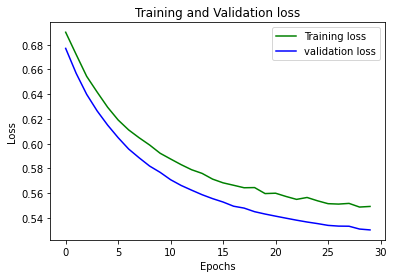

In [16]:
epochs = range(EPOCHS)
plt.plot(epochs, train_losses, 'g', label='Training loss')
plt.plot(epochs, valid_losses, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Performance on Test Set

In [17]:
model.load_state_dict(torch.load("model_weights.pt"))
_ = evaluate(test_loader)


Evaluating...


              precision    recall  f1-score   support

           0       0.77      0.76      0.76      1341
           1       0.73      0.74      0.74      1193

    accuracy                           0.75      2534
   macro avg       0.75      0.75      0.75      2534
weighted avg       0.75      0.75      0.75      2534

